# SOFR LIBOR SWAP RATE

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

swapLiborRateDataFilePath = "data/swapLiborRate_raw.xlsx"
swapSofrRateFilePath = "data/swapSofrRate_raw.xlsx"

In [29]:
def combineDf(tenors, swapRateDataFilePath,bloombergPrefix):
    combinedDf = None
    for tenor in tenors:
        sheet_name = bloombergPrefix + str(tenor)
        # Read the sheet from the Excel file
        df = pd.read_excel(swapRateDataFilePath, sheet_name=sheet_name)

        # Ensure Date is in datetime format (adjust column name if needed)
        df['Date'] = pd.to_datetime(df['Date'])

        # Select the Date and Last Price columns
        # If the last price column is named differently, update the column name accordingly.
        df_subset = df[['Date', 'Last Price']].copy()

        # Rename the Last Price column to include the tenor (e.g., USSWAP1, USSWAP2, etc.)
        df_subset.rename(columns={'Last Price': f'USSWAP{tenor}'}, inplace=True)

        # Merge with the combined DataFrame on Date using an outer join
        if combinedDf is None:
            combinedDf = df_subset
        else:
            combinedDf = pd.merge(combinedDf, df_subset, on='Date', how='outer')
    combinedDf=combinedDf.dropna()
    combinedDf.sort_values('Date', inplace=True)
    combinedDf.reset_index(drop=True, inplace=True)
    return combinedDf

In [ ]:
liborTenors = [1,2,3,4,5,6,7,8,9,10,15,20,25,30]
liborCombinedDf=combineDf(liborTenors, swapLiborRateDataFilePath, bloombergPrefix='USSWAP')

# Display the combined DataFrame
# liborCombinedDf.to_csv("LIBOR_swaprates.csv")
liborCombinedDf.tail()

In [33]:
# 1M,3M, 6M, 9M, 1Y, 1.5Y, 2Y,....
sofrTenors = ['A','C', 'F', 'I',1,'1F',2,3,4,5,6,7,8,9,10,15,20,25,30]

sofrCombinedDf=combineDf(sofrTenors, swapSofrRateFilePath, bloombergPrefix='USOSFR')

# Display the combined DataFrame
sofrCombinedDf.to_csv("SOFR_swaprates.csv")
sofrCombinedDf.tail(40)

,Date,USSWAPA,USSWAPC,USSWAPF,USSWAPI,USSWAP1,USSWAP1F,USSWAP2,USSWAP3,USSWAP4,USSWAP5,USSWAP6,USSWAP7,USSWAP8,USSWAP9,USSWAP10,USSWAP15,USSWAP20,USSWAP25,USSWAP30
2823,2024-12-23,4.34250,4.32790,4.28430,4.25530,4.23920,4.17280,4.16001,4.13205,4.11185,4.10125,4.09665,4.09420,4.09370,4.09575,4.10060,4.13300,4.11050,4.03060,3.93675
2824,2024-12-24,4.35100,4.33085,4.28400,4.25030,4.23115,4.16473,4.15350,4.12735,4.11225,4.10350,4.09595,4.09430,4.09075,4.09255,4.09965,4.12745,4.10245,4.02530,3.92400
2825,2024-12-26,4.35730,4.32180,4.27515,4.24300,4.22420,4.15780,4.14620,4.11730,4.09650,4.08500,4.08250,4.08300,4.08496,4.08795,4.09475,4.13215,4.11205,4.03250,3.93900
2826,2024-12-27,4.34950,4.31475,4.26650,4.23205,4.21420,4.15520,4.15010,4.13315,4.12175,4.11780,4.11969,4.12325,4.12655,4.13180,4.13960,4.18075,4.16185,4.08300,3.99000
2827,2024-12-30,4.33335,4.30550,4.24855,4.20050,4.17110,4.09365,4.07660,4.04755,4.02895,4.02031,4.02224,4.02620,4.03080,4.03691,4.04570,4.09400,4.07950,4.00375,3.91295
2828,2024-12-31,4.32315,4.30200,4.24950,4.20500,4.17587,4.10495,4.07760,4.05455,4.04150,4.03850,4.04350,4.04905,4.05536,4.06240,4.07100,4.11888,4.10150,4.02545,3.93352
2829,2025-01-02,4.31300,4.29325,4.24425,4.20280,4.17620,4.09985,4.08195,4.05395,4.04025,4.03565,4.03820,4.04225,4.04700,4.05350,4.06202,4.11050,4.09605,4.02130,3.93105
2830,2025-01-03,4.30760,4.29090,4.25175,4.21610,4.19550,4.12840,4.11715,4.09377,4.07990,4.07440,4.07490,4.07795,4.08175,4.08728,4.09495,4.13990,4.12565,4.05125,3.96130
2831,2025-01-06,4.30080,4.28910,4.25315,4.21780,4.19623,4.13095,4.12565,4.11598,4.11265,4.11360,4.11806,4.12405,4.13065,4.13840,4.14750,4.19435,4.18085,4.10650,4.01635
2832,2025-01-07,4.30295,4.29350,4.26200,4.22990,4.20900,4.14504,4.14000,4.13510,4.13985,4.14825,4.15810,4.16825,4.17790,4.18795,4.19950,4.25150,4.24085,4.16816,4.07900


In [28]:
sofrCombinedDf.head()

,Date,USSWAPA,USSWAPC,USSWAPF,USSWAPI,USSWAP1,USSWAP1F,USSWAP2,USSWAP3,USSWAP4,USSWAP5,USSWAP6,USSWAP7,USSWAP8,USSWAP9,USSWAP10,USSWAP15,USSWAP20,USSWAP25,USSWAP30
3,2013-02-01,0.1736,0.1702,0.1672,0.1696,0.1721,0.18695,0.2222,0.3371,0.5287,0.767,1.00849,1.24909,1.45502,1.64239,1.81004,2.35306,2.58648,2.70148,2.76646
5,2013-02-05,0.1726,0.1692,0.1662,0.1686,0.1711,0.18595,0.2202,0.3341,0.5187,0.749,0.99227,1.23087,1.43660,1.62223,1.79224,2.33643,2.57469,2.69069,2.75682
6,2013-02-06,0.1761,0.1707,0.1657,0.1661,0.1651,0.17795,0.2092,0.3141,0.4937,0.720,0.95569,1.19454,1.39898,1.58407,1.75305,2.29681,2.53503,2.65047,2.71506
7,2013-02-07,0.1801,0.1747,0.1707,0.1701,0.1681,0.17895,0.2112,0.3131,0.4907,0.716,0.95058,1.18968,1.39425,1.58022,1.75158,2.29204,2.52847,2.64310,2.70800
8,2013-02-08,0.1801,0.1747,0.1707,0.1701,0.1701,0.17895,0.2112,0.3111,0.4877,0.712,0.95213,1.18773,1.39205,1.57576,1.74386,2.28329,2.51966,2.63337,2.69695


# SOFR LIBOR RATE

This document aim to explore how to create synthetic SOFR rate based on LIBOR rate based on the guide: https://www.isda.org/a/fp8gE/Fallbacks_FAQ_V13_August-2024.pdf

There are two purposed method:
1. To directly use SOFR FALLBACK rate on Bloomberg as the syntehtic SOFR rate
2. Following the guide of ISDA, self - compute the median between SOFR and LIBOR for previous 5 year and use that as spread adjustment then self compound the rates

From cross checking, the SOFR Fallback(T+2) matches exactly with the overnight sofr rate and the method of computing median also generate very small spread. For simplicity, we'll use the SOFR Fallback rate to generate synthetic swaption data first.

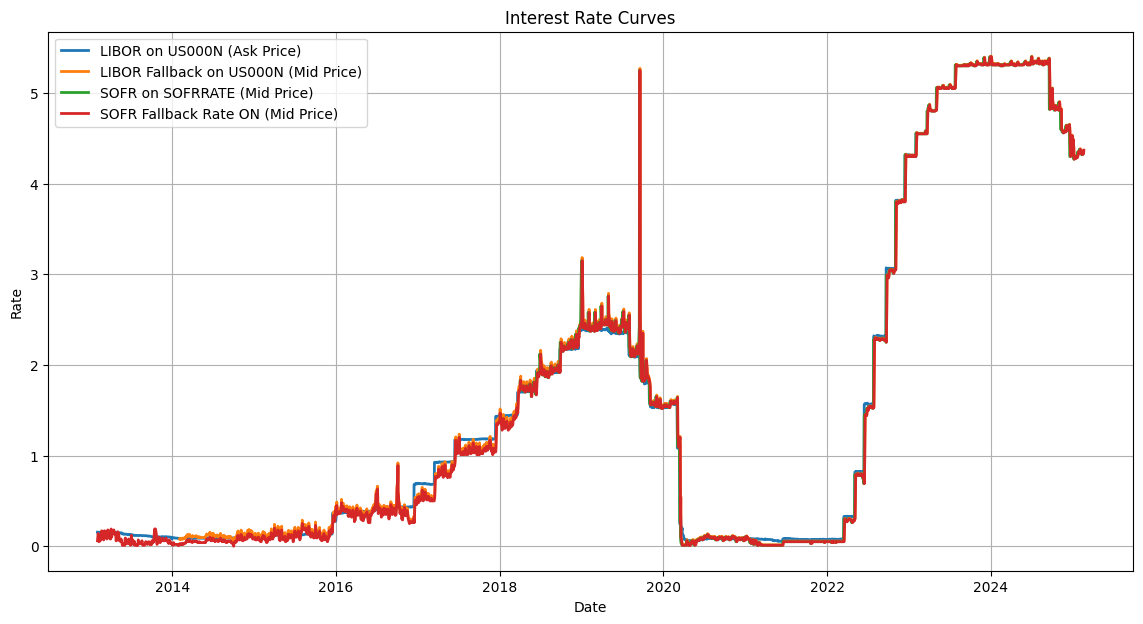

In [35]:
# File name (adjust if your file is named differently, e.g. "3monLibor.xlsx")
overnightDataFilePath = "data/liborDataON.xlsx"  # if it's an Excel file with .csv extension, otherwise use .xlsx
sofrFallbackFilePath = "data/sofrFallback.xlsx"

# Load overnight data
df_libor_on    = pd.read_excel(overnightDataFilePath, sheet_name='US000N')
df_libor_on_fallback = pd.read_excel(overnightDataFilePath, sheet_name='VUS000N')
df_sofr_on     = pd.read_excel(overnightDataFilePath, sheet_name='SOFRRATE')
df_sofr_on_fallback     = pd.read_excel(sofrFallbackFilePath, sheet_name='XSOFRON')

# Ensure the 'date' columns are parsed as datetime objects
df_libor_on['date']    = pd.to_datetime(df_libor_on['Date'])
df_libor_on_fallback['date'] = pd.to_datetime(df_libor_on_fallback['Date'])
df_sofr_on['date']     = pd.to_datetime(df_sofr_on['Date'])
df_sofr_on_fallback['date']     = pd.to_datetime(df_sofr_on_fallback['Date'])

# Optionally sort by date if not already sorted
df_libor_on    = df_libor_on.sort_values('date')
df_libor_on_fallback = df_libor_on_fallback.sort_values('date')
df_sofr_on     = df_sofr_on.sort_values('date')
df_sofr_on_fallback = df_sofr_on_fallback.sort_values('date')

# Plotting the curves on the same figure
plt.figure(figsize=(14, 7))
plt.plot(df_libor_on['date'], df_libor_on['Ask Price'], label='LIBOR on US000N (Ask Price)', linewidth=2)
plt.plot(df_libor_on_fallback['date'], df_libor_on_fallback['Mid Price'], label='LIBOR Fallback on US000N (Mid Price)', linewidth=2)
plt.plot(df_sofr_on['date'], df_sofr_on['Mid Price'], label='SOFR on SOFRRATE (Mid Price)', linewidth=2)
plt.plot(df_sofr_on_fallback['date'], df_sofr_on_fallback['Mid Price'], label='SOFR Fallback Rate ON (Mid Price)', linewidth=2)

plt.xlabel("Date")
plt.ylabel("Rate")
plt.title("Interest Rate Curves")
plt.legend()
plt.grid(True)
plt.show()

In [27]:
merged_df = pd.merge(
    df_sofr_on_fallback[['date', 'Mid Price']],
    df_sofr_on[['date', 'Mid Price']],
    on='date',
    how='inner',
    suffixes=('_sofr_fallback', '_sofr')
)
merged_df['diff']=merged_df['Mid Price_sofr_fallback']-merged_df['Mid Price_sofr']
print(merged_df)

           date  Mid Price_sofr_fallback  Mid Price_sofr  diff
0    2018-04-02                     1.72            1.80 -0.08
1    2018-04-03                     1.80            1.83 -0.03
2    2018-04-04                     1.80            1.74  0.06
3    2018-04-05                     1.83            1.75  0.08
4    2018-04-06                     1.74            1.75 -0.01
...         ...                      ...             ...   ...
1712 2025-02-07                     4.33            4.35 -0.02
1713 2025-02-10                     4.36            4.35  0.01
1714 2025-02-11                     4.35            4.34  0.01
1715 2025-02-12                     4.35            4.32  0.03
1716 2025-02-13                     4.34             NaN   NaN

[1717 rows x 4 columns]


In [28]:
merged_df[abs(merged_df['diff'])>1]

,date,Mid Price_sofr_fallback,Mid Price_sofr,diff
366,2019-09-17,2.20,5.25,-3.05
368,2019-09-19,5.25,1.95,3.30


Adjust rate to accomodation for sofr being calculated in arrear and libor being forward looking rate.Considering T+2 being settlement rate and by observing the curve, we shift sofr 2 days forward (i.e put sofr on 2018-04-01 to 2018-04-04)

In [29]:
merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df = merged_df.sort_values('date').reset_index(drop=True)
merged_df['Mid Price_sofr_shifted'] = merged_df['Mid Price_sofr'].shift(+2) # cuz T+2 settlement
merged_df['shifted_diff']=merged_df['Mid Price_sofr_fallback']-merged_df['Mid Price_sofr_shifted']
# merged_df['capped diff'] = merged_df['diff'].clip(lower=-1, upper=1)
merged_df

,date,Mid Price_sofr_fallback,Mid Price_sofr,diff,Mid Price_sofr_shifted,shifted_diff
0,2018-04-02,1.72,1.80,-0.08,NaN,NaN
1,2018-04-03,1.80,1.83,-0.03,NaN,NaN
2,2018-04-04,1.80,1.74,0.06,1.80,0.0
3,2018-04-05,1.83,1.75,0.08,1.83,0.0
4,2018-04-06,1.74,1.75,-0.01,1.74,0.0
...,...,...,...,...,...,...
1712,2025-02-07,4.33,4.35,-0.02,4.33,0.0
1713,2025-02-10,4.36,4.35,0.01,4.36,0.0
1714,2025-02-11,4.35,4.34,0.01,4.35,0.0
1715,2025-02-12,4.35,4.32,0.03,4.35,0.0


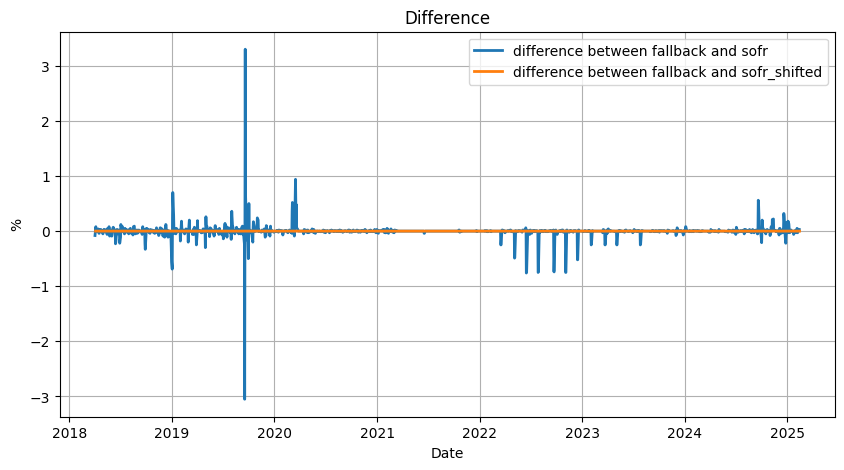

In [30]:
# Plotting the curves on the same figure
plt.figure(figsize=(10, 5))
# plt.plot(df_libor['date'], df_libor['Ask Price'], label='LIBOR on US000N (Ask Price)', linewidth=2)
plt.plot(merged_df['date'], merged_df['diff'], label='difference between fallback and sofr', linewidth=2)
plt.plot(merged_df['date'], merged_df['shifted_diff'], label='difference between fallback and sofr_shifted', linewidth=2)

plt.xlabel("Date")
plt.ylabel("%")
plt.title("Difference")
plt.legend()
plt.grid(True)
plt.show()

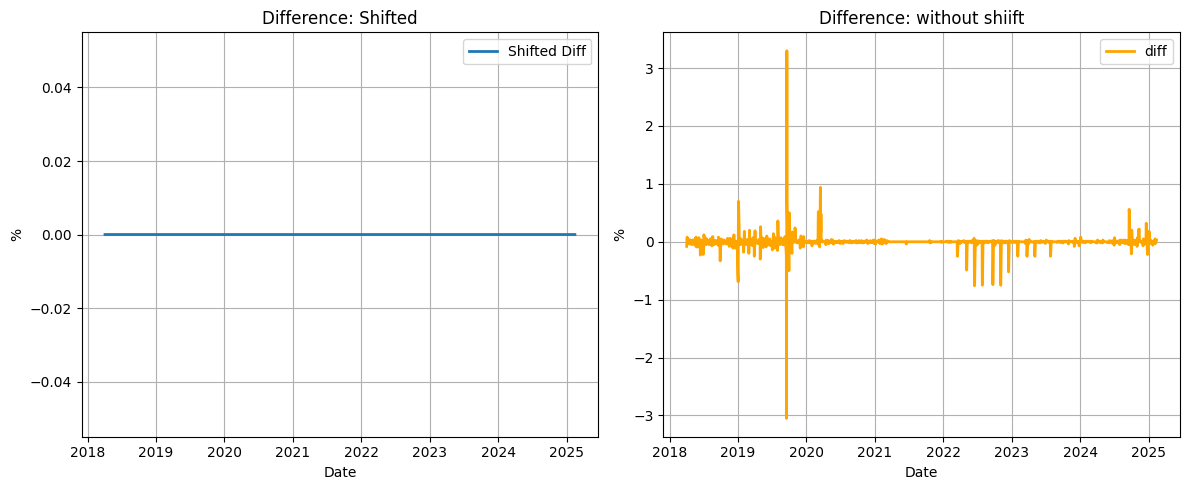

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the shifted_diff on the first subplot
axs[0].plot(merged_df['date'], merged_df['shifted_diff'], label='Shifted Diff', linewidth=2)
axs[0].set_xlabel("Date")
axs[0].set_ylabel("%")
axs[0].set_title("Difference: Shifted")
axs[0].legend()
axs[0].grid(True)

# Plot the capped diff on the second subplot
axs[1].plot(merged_df['date'], merged_df['diff'], label='diff', linewidth=2, color='orange')
axs[1].set_xlabel("Date")
axs[1].set_ylabel("%")
axs[1].set_title("Difference: without shiift")
axs[1].legend()
axs[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [32]:
merged_df.describe()

,date,Mid Price_sofr_fallback,Mid Price_sofr,diff,Mid Price_sofr_shifted,shifted_diff
count,1717,1717.000000,1716.000000,1716.000000,1715.000000,1715.0
mean,2021-09-05 18:13:37.705299968,2.381444,2.383298,-0.002995,2.382169,0.0
min,2018-04-02 00:00:00,0.010000,0.010000,-3.050000,0.010000,0.0
25%,2019-12-18 00:00:00,0.090000,0.090000,-0.010000,0.090000,0.0
50%,2021-09-03 00:00:00,2.150000,2.150000,0.000000,2.150000,0.0
75%,2023-05-25 00:00:00,4.580000,4.580000,0.010000,4.580000,0.0
max,2025-02-13 00:00:00,5.400000,5.400000,3.300000,5.400000,0.0
std,NaN,2.017742,2.018760,0.140601,2.018807,0.0


By checking the shifted_diff, we do see that the difference mean and standarddeviation are both around ~1bps.

## Method 2


In [24]:
merged_spread = pd.merge(
    df_libor_on[['date', 'Ask Price']],
    df_sofr_on[['date', 'Mid Price']],
    on='date',
    how='inner',
    suffixes=('_libor', '_sofr')
)
days = str(252*5)+'D'
# Calculate the daily spread: LIBOR Ask Price minus SOFR Mid Price
merged_spread['spread'] = merged_spread['Ask Price'] - merged_spread['Mid Price']

# Set the date column as the index to enable time-based rolling window
merged_spread = merged_spread.sort_values('date').set_index('date')

# Compute the rolling median spread over a 5-year window (approx. 1825 days)
merged_spread['rolling_spread'] = merged_spread['spread'].rolling(days).median()
merged_spread['synthetic_sofr_on'] = merged_spread['Ask Price']-merged_spread['spread']
merged_spread['diff'] = merged_spread['synthetic_sofr_on']-merged_spread['Mid Price']

# Optionally, reset the index if you need 'date' as a column later:
merged_spread.reset_index(inplace=True)

print(merged_spread.head())

        date  Ask Price  Mid Price   spread  rolling_spread  \
0 2018-04-03    1.69938       1.83 -0.13062        -0.13062   
1 2018-04-04    1.70188       1.74 -0.03812        -0.08437   
2 2018-04-05    1.70313       1.75 -0.04687        -0.04687   
3 2018-04-06    1.70313       1.75 -0.04687        -0.04687   
4 2018-04-09    1.70188       1.75 -0.04812        -0.04687   

   synthetic_sofr_on  diff  
0               1.83   0.0  
1               1.74   0.0  
2               1.75   0.0  
3               1.75   0.0  
4               1.75   0.0  


In [25]:
merged_spread.describe()

,date,Ask Price,Mid Price,spread,rolling_spread,synthetic_sofr_on,diff
count,1186,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1.186000e+03
mean,2020-08-29 16:58:41.079257856,1.263794,1.266509,-0.002715,-0.011939,1.266509,-8.922271e-20
min,2018-04-03 00:00:00,0.050750,0.010000,-3.095120,-0.130620,0.010000,-2.775558e-17
25%,2019-06-17 06:00:00,0.080000,0.050000,-0.018467,-0.021185,0.050000,0.000000e+00
50%,2020-08-26 12:00:00,1.536190,1.540000,0.007690,-0.015153,1.540000,0.000000e+00
75%,2021-11-09 18:00:00,2.179255,2.227500,0.029358,-0.005075,2.227500,0.000000e+00
max,2023-02-03 00:00:00,4.552710,5.250000,0.279880,0.022130,5.250000,8.673617e-18
std,NaN,1.185326,1.210903,0.109505,0.015293,1.210903,1.491383e-18
